In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2021-03-19 17:29:49--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2021-03-19 17:29:49 (5.18 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



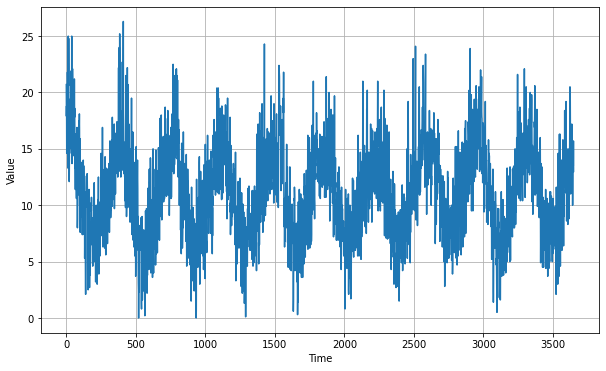

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=",")
  next(reader)
  for i, row in enumerate(reader):
    temps.append(float(row[1]))
    time_step.append(int(i))

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [10]:
split_time = 2500
time_train = time[split_time:]
x_train = series[split_time:]
time_valid = time[:split_time]
x_valid = series[:split_time]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

In [12]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                                                           strides=1, padding="causal",
                                                           activation="relu",
                                                           input_shape=[None, 1]),
                                                           tf.keras.layers.LSTM(64, return_sequences=True),
                                                           tf.keras.layers.LSTM(64, return_sequences=True),
                                                           tf.keras.layers.Dense(30, activation="relu"),
                                                           tf.keras.layers.Dense(10, activation="relu"),
                                                           tf.keras.layers.Dense(1),
                                                           tf.keras.layers.Lambda(lambda x: x * 400)
])
                                    
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)                           
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=["mae"])
#history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1150,)


(1e-08, 0.0001, 0.0, 60.0)

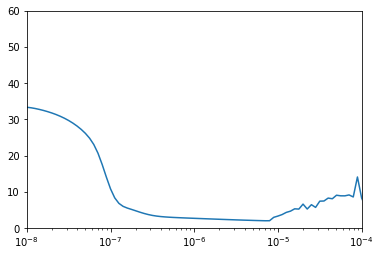

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [42]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                                                           strides=1, padding="causal",
                                                           activation="relu",
                                                           input_shape=[None, 1]),
                                                           tf.keras.layers.LSTM(64, return_sequences=True),
                                                           tf.keras.layers.LSTM(64, return_sequences=True),
                                                           tf.keras.layers.Dense(30, activation="relu"),
                                                           tf.keras.layers.Dense(30, activation="relu"),
                                                           tf.keras.layers.Dense(1),
                                                           tf.keras.layers.Lambda(lambda x: x * 400)
])
                                    
                      
optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=30)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1150,)
Epoch 1/30
11/11 [==============================] - 5s 130ms/step - loss: 14.6180 - mae: 15.1139
Epoch 2/30
11/11 [==============================] - 2s 129ms/step - loss: 5.1588 - mae: 5.6389
Epoch 3/30
11/11 [==============================] - 2s 127ms/step - loss: 2.7537 - mae: 3.2209
Epoch 4/30
11/11 [==============================] - 2s 128ms/step - loss: 2.3457 - mae: 2.8088
Epoch 5/30
11/11 [==============================] - 2s 129ms/step - loss: 2.2431 - mae: 2.7047
Epoch 6/30
11/11 [==============================] - 2s 128ms/step - loss: 2.1672 - mae: 2.6270
Epoch 7/30
11/11 [==============================] - 2s 129ms/step - loss: 2.1193 - mae: 2.5780
Epoch 8/30
11/11 [==============================] - 2s 131ms/step - loss: 2.0626 - mae: 2.5201
Epoch 9/30
11/11 [==============================] - 2s 128ms/step - loss: 2.0354 - mae: 2.4927
Epoch 10/30
11/11 [======================

In [37]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

ValueError: ignored

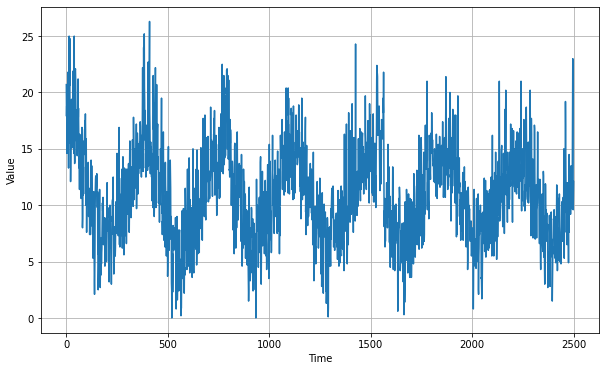

In [38]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)